In [1]:
from imports import *

+--------------------------+---------------------------------------------------+
|          Field           |                       Value                       |
+--------------------------+---------------------------------------------------+
|            IP            |                  100.113.141.113                  |
|         Devices          |              ['INV2', 'TEMP', 'HUM']              |
|    Time absolut start    |                2024-08-24T00:00:00Z               |
|     Time absolut end     |                2024-08-25T00:00:00Z               |
|        Time range        |                        None                       |
|     Time resolution      |                         1m                        |
|   Prediction horizont    |                         15                        |
| Prediction horizont unit |                        min                        |
|        Delimiter         |                         ;                         |
|           CWD            |

<AxesSubplot: xlabel='Date'>

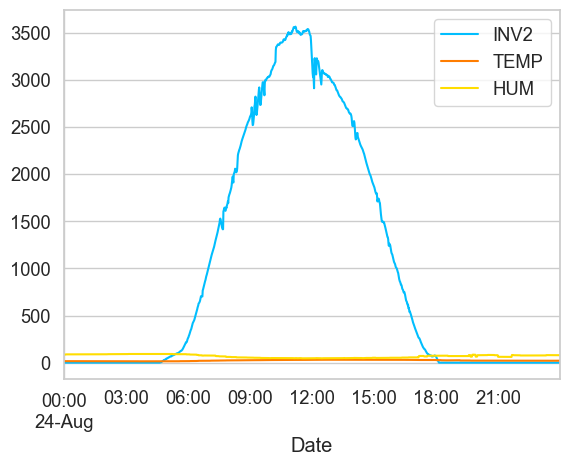

In [2]:
# Load df directly from IoT Server --> only working within the Tailscale VPN connection
ip = "100.113.141.113"
devices = ["INV2", "TEMP", "HUM"] # First device defines the value to be forecasted
time_abs_start = "2024-08-24T00:00:00Z"
time_abs_end   = "2024-08-25T00:00:00Z"
time_range = "None"
res = "1m"

iot_server = IotGrabber(
                          ip=ip,
                          devices=devices,
                          time_abs_start=time_abs_start,
                          time_abs_end=time_abs_end,
                          range=time_range,
                          res=res,
                          delimiter=";",
                          cwd=os.getcwd()
                          )
iot_server.setRange(time_range)

print(iot_server)
df = iot_server.get_df()

print(df)

df.plot()

In [ ]:
"""
# Normal data set
df = pd.read_csv("data.csv", delimiter=";")
df["Date"] = pd.to_datetime(df['Date']) #, dayfirst=True

# Set Index
df.set_index("Date", inplace=True)

# Inspect the data
print(df.head())
print(df.info())
df.plot()
plt.show()"""

0.3740494667348353

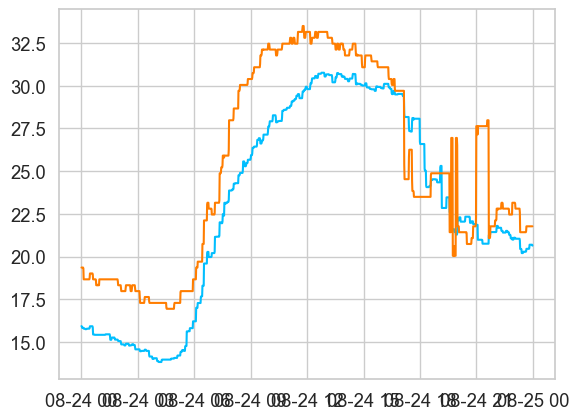

In [9]:
plt.plot(df.index, df.TEMP)
plt.plot(df.index, df.HUM*-0.34460+49)
foo = df.TEMP / df.HUM
foo.mean()

In [29]:
import math
from sklearn.preprocessing import MinMaxScaler


train_data = df.copy(deep=True)

# Use second column here --> instead of "Date" use "Open", which stands for INV2 power
# train_data = df[:training_data_len].iloc[:, 1:2]
# test_data = df[training_data_len:].iloc[:, 1:2]

print(train_data.shape)

# Selecting Open Price values
dataset_train = train_data.INV2.values
# dataset_train = df
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3  # Increased number of layers (3)
hidden_size = 128  # Increased number of hidden units (128)
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
model.load_state_dict(torch.load("results/2024-10-01_all-data-model/trained-model.pytorch"))
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

(1440, 3)
(1440, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
torch.Size([1390, 50, 1]) torch.Size([1390, 1])
cpu


D:\temp\ipykernel_20356\539061953.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/2024-10-01_all-data-model/trained-model.pyto

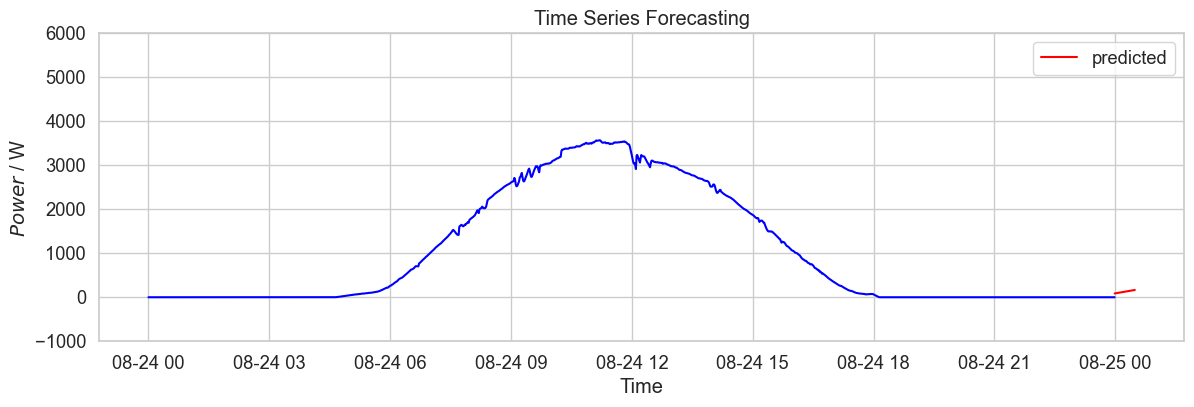

D:\temp\ipykernel_20356\3166319534.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Last historical value: {df.index[-1]} {df.INV2[-1]}")
D:\temp\ipykernel_20356\3166319534.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Next prediction value: {predicted.index[-1]} {predicted.Predict[-1]}")


Last historical value: 2024-08-24 23:59:00 0.0
Next prediction value: 2024-08-25 00:29:00 165.4916229248047
Current directory before change: x:\git\LRZ\masters-thesis\pytorch\inv2-input
Current directory after change: x:\git\LRZ\masters-thesis\pytorch\inv2-input
Request failed with status code 404


IndexError: index 2 is out of bounds for axis 0 with size 0

In [21]:
num_forecast_steps = 2 # (30)
time_freq = f"{num_forecast_steps*15}min"
sequence_to_plot = X_train.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = train_data.index[-2]
future_dates = pd.date_range(start=last_date + pd.Timedelta(1, unit='m'), periods=num_forecast_steps, freq=time_freq) # add 1 min steps to the df
#future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
forecasted = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()
predicted = pd.DataFrame()
predicted.insert(0, "Date", future_dates)
predicted.insert(1, "Predict", forecasted*1.19)
predicted.set_index("Date", inplace=True)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(df.index, df.INV2, color="blue") # Plot Inverter Power
plt.plot(predicted.index[:], predicted[:], label='predicted', color='red') # Plot prediction

plt.xlabel('Time')
plt.ylabel('$Power$ / W')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.ylim(-1000,6000)
plt.show()

print(f"Last historical value: {df.index[-1]} {df.INV2[-1]}")
print(f"Next prediction value: {predicted.index[-1]} {predicted.Predict[-1]}")

# Save predictions
predicted.to_csv(f"predicted.csv")

# Compare prediction with the truth
dTime = pd.Timedelta(num_forecast_steps*15, unit='m')
end_time = df.index[-1] + dTime

iot_server.setTimeAbsStart(iot_server.timeToStr(df.index[-1]))
iot_server.setTimeAbsEnd(iot_server.timeToStr(end_time))

df_compare_with = iot_server.get_df()
dPrediction = df_compare_with.INV2 - predicted.Predict 

# Plot prediciton with truth
plt.plot(df_compare_with.index, df_compare_with.INV2, color="b")
plt.plot(predicted.index, predicted.Predict, color="r")

# Calc RMSE
rmse = ((df_compare_with.INV2 - predicted.Predict) ** 2).mean() ** .5
print(f"RMSE: {rmse}")

In [22]:
predicted.Predict.mean()

125.81119

In [23]:
df_compare_with.INV2.mean()

NameError: name 'df_compare_with' is not defined

In [ ]:
predicted.plot()
df_compare_with.INV2.mean() / predicted.Predict.mean()

In [ ]:
df_compare_with